ver: 20201016.1257

In [99]:
# Initialization for this notebook.

import numpy as np
import matplotlib.pyplot as plt

# Un-comment the following line to use interactive matplotlib widget.
#%matplotlib widget

# Returns a n seqence based on the offset provided.
seq_n = lambda seq, noff: np.arange(seq.size) - noff

# Pretty print a sequence.
seq_print = lambda seq, noff, name: print('noff_%s =%2d, %s =' % (name, noff, name), seq.astype(float))

# Common sequence generators.
seq_delta = lambda n_min, n_max: (np.array([ 1 if n==0 else 0 for n in range(n_min, n_max+1)]), 0 - n_min)
seq_u = lambda n_min, n_max: (np.array([ 0 if n<0 else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_R_N = lambda N, n_min, n_max: (np.array([ 0 if (n<0 or n>=N) else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_real_exp = lambda a, n_min, n_max: (np.array([ 0 if n<0 else a**n for n in range(n_min, n_max+1)]), 0-n_min)
seq_complex_exp = lambda sigma, omega_0, n_min, n_max: (np.array([ np.exp((sigma + 1j*omega_0)*n) for n in range(n_min, n_max+1)]), 0-n_min)
seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in range(n_min, n_max+1)]), 0-n_min)

# Returns a flipped sequence.
seq_flip = lambda seq, noff: (seq[::-1], seq.size - noff - 1)

# Returns a shifted sequence.
seq_shift = lambda seq, noff, m: (seq, noff - m)

# Align 2 sequences
def seq_align(seq1, noff1, seq2, noff2):
    """Align 2 sequences"""
    n_min = min(-noff1, -noff2)
    n_max = max(seq1.size-noff1-1, seq2.size-noff2-1)
    seq1 = np.pad(seq1, (-noff1-n_min, n_max-(seq1.size-noff1-1)), constant_values=(0,0))
    noff1 = -n_min
    seq2 = np.pad(seq2, (-noff2-n_min, n_max-(seq2.size-noff2-1)), constant_values=(0,0))
    noff2 = -n_min
    return (seq1, noff1, seq2, noff2)

def plotVertical(title, plotData):
    """
        Parameters:
        title: plot title string
        plotData: tuple array, contains data to plot
        [(seq, noff, label), ...]
    """
    # Get the row number
    row = len(plotData)
    # Create a plot, which plots data sequence vertically, shares the same X and Y axis
    _, axe = plt.subplots(row, 1, sharex=True, sharey=True)
    axe[0].set_title(title)
    for i in range(row):
        # Get the arguments
        seq, offset, label = plotData[i]
        # Create a stem plot for seq
        axe[i].stem(seq_n(seq, offset), seq)
        # Set Y label
        axe[i].set_ylabel(label)
    # Set X label at the bottom
    axe[-1].set_xlabel('n')

def seq_conv(seq1, noff1, seq2, noff2):
    """
    Returns the discrete, linear convolution of two sequences.

    Parameters:
        seq1, seq2: array_like
            The 2 input sequences.
        noff1, noff： int
            n's offsets of the 2 input sequences.
    Returns: (seq, noff)
        seq: array_like
            The output sequence.
        noff: int
            n's offset of the output sequence.
    """
    # Flip seq2
    seq2Flipped, noff2Flipped = seq_flip(seq2, noff2)
    # Range of the result sequence, nEnd is exclusive
    (nStart, nEnd) = (-(noff1 + noff2),
                      (seq2.size - noff2 - 1) + (seq1.size - noff1 - 1) + 1)
    # Result sequence length
    resultLen = nEnd - nStart
    resultSeq = np.empty([resultLen], dtype=seq1.dtype)
    # Foreach n to create the result sequence
    for n in range(nStart, nEnd):
        # Shift h(n), which is seq2
        seq2Shifted, noff2Shifted = seq_shift(seq2Flipped, noff2Flipped, n)
        # Align the h(n) and x(n)
        seq1Aligned, _, seq2Aligned, _ = seq_align(
            seq1, noff1, seq2Shifted, noff2Shifted)
        # Multiply two aligned sequence and sum it up
        resultSeq[n - nStart] = (seq1Aligned * seq2Aligned).sum()
    # Return the result sequence and its noff
    return resultSeq, noff1

## 习题1.14

### (1) 求该系统的单位抽样响应

In [100]:
class T_stream:
    """A class to process input stream, i.e. one value at a time."""

    # 存储上一个h(n)的输出，由于是因果系统，其单位冲击响应h(n)=0, n<0，所以初始值设为0
    h_z1 = 0
    # 存储上一个输入的x(n)
    x_z1 = 0

    def process(self, x):
        """Process one single input value x[n] and return y[n]."""

        # h[n] = x(n) + 1/2 * x(n-1) + 1/2 * h(n-1)
        h = x + 1/2 * self.x_z1 + 1/2 * self.h_z1

        # Store the h[n], so that when process() is called next time, it will be h[n-1]
        self.h_z1 = h
        # Store the x[n], so that when process() is called next time, it will be x[n-1]
        self.x_z1 = x

        return h


def seq_response(x, noff_x):
    """
    根据输入的单位冲击响应x(n)计算响应h(n)
    """
    def h(n):
        """Calculate the h(n)"""
        u, _ = seq_u(n-1, n-1)
        delta, _ = seq_delta(n, n)
        return ((1/2) ** (n-1)) * u[0] + delta[0]

    n_min = -noff_x
    n_max = x.size - noff_x - 1
    return np.array([h(n) for n in range(n_min, n_max+1)]), noff_x


单元测试：输入 $ δ(n) $，预期输出为 $ h(n) = (\frac{1}{2})^{n-1} * u(n-1) + δ(n) $

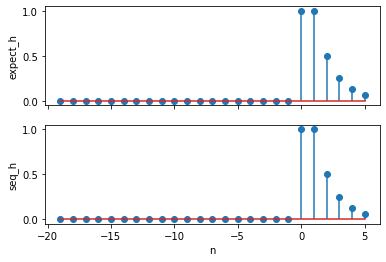

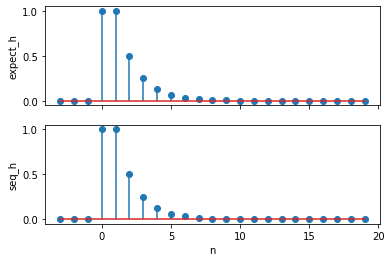

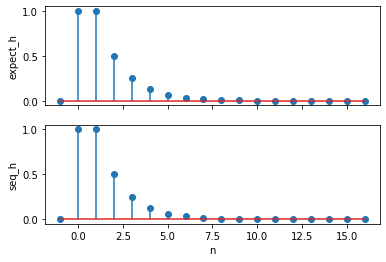

In [101]:
def test_seq_h():
    # Define input sequence.
    (n_min, n_max) = (np.random.randint(-20, 0), np.random.randint(0, 20))
    (x, noff_x) = seq_delta(n_min, n_max)

    # Create a T_stream object.
    t_stream = T_stream()

    # Process the input sequence one value at a time.
    (seq_expect_h, noff_expect_h) = (
        np.array([t_stream.process(x_i) for x_i in x]), noff_x)

    seq_h, noff_h = seq_response(x, noff_x)

    # Check if the expect seq equals the seq produced by T_stream
    assert (seq_expect_h - seq_h < 0.00001).all(
    ), f'Expect:{seq_expect_h}, Actual:{seq_h}'
    # Plot image
    plotVertical('', [
        (seq_expect_h, noff_expect_h, 'expect_h'),
        (seq_h, noff_h, 'seq_h')
    ])

for _ in range(3):
    test_seq_h()


### (2) 由(1)的结果，利用卷积和求输入 $ x(n)=e^{jωn} $ 的响应，其中 $ ω=\frac{Π}{8} $

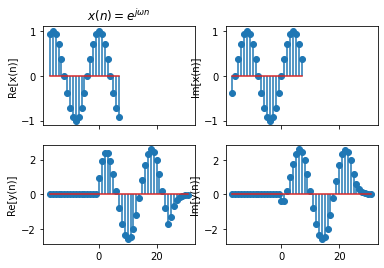

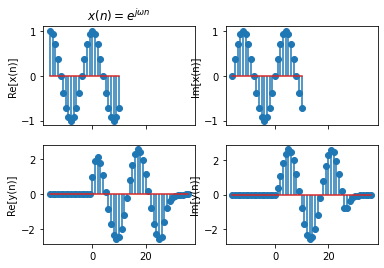

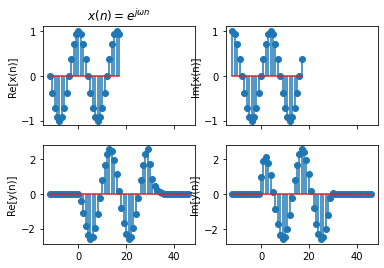

In [103]:
# $ x(n)=e^{jωn} $ while $ ω=\frac{Π}{8} $
def seq_x(n_min, n_max):
    return seq_complex_exp(sigma=0, omega_0=np.pi/8, n_min=n_min, n_max=n_max)


def test_conv_response():
    # Define delta sequence.
    (n_min, n_max) = (np.random.randint(-20, 0), np.random.randint(0, 20))
    (delta, noff_delta) = seq_delta(n_min, n_max)

    # Get impuse response
    (h, noff_h) = seq_response(delta, noff_delta)

    # Define x sequence
    (x, noff_x) = seq_x(n_min, n_max)

    # Calc the conv
    (y, noff_y) = seq_conv(x, noff_x, h, noff_h)

    # Plot the sequence
    _, axes = plt.subplots(2, 2, sharex=True)
    axes[0, 0].set_title('$ x(n)=e^{jωn} $')
    
    axes[0, 0].stem(seq_n(x, noff_x), x.real)
    axes[0, 0].set_ylabel('Re[x(n)]')
    axes[0, 1].stem(seq_n(x, noff_x), x.imag)
    axes[0, 1].set_ylabel('Im[x(n)]')

    axes[1,0].stem(seq_n(y, noff_y), y.real)
    axes[1,0].set_ylabel('Re[y(n)]')
    axes[1,1].stem(seq_n(y, noff_y), y.imag)
    axes[1,1].set_ylabel('Im[y(n)]')


for _ in range(3):
    test_conv_response()
